In [1]:
from basic_imports import *
from torch_imports import *
import glob
import unicodedata
import string

## Config

In [147]:
class Config:
    datadir = 'data/names/*.txt'
    batch_size = 16
    hidden_dim = 128
    lr = 0.03
    device = 'cuda:1'
    num_layers = 1
    num_epochs = 7
config = Config()

## Dataset and Dataloader

In [148]:
def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(config.datadir):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(category_lines.keys())

In [149]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = np.zeros((1, n_letters))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
# def lineToTensor(lines, max_len):
#     tensor = np.zeros((len(lines), max_len, n_letters))
#     seq_lens = np.zeros(len(lines))
#     for wi, word in enumerate(lines):
#         seq_lens[wi] = len(word)
#         for li, letter in enumerate(word):
#             tensor[wi][li][letterToIndex(letter)] = 1
#     return tensor, seq_lens

def lineToTensor(lines):
    word_list = []
    for word in lines:
        letter_list = []
        for l in word:
            letter_list.append(letterToIndex(l))
        word_list.append(letter_list)
    return np.array(word_list)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [150]:
max_len = max([len(o) for k in category_lines.keys() for o in category_lines[k]])


trn_xs, trn_ys, val_xs, val_ys = [], [], [], []

for k in category_lines.keys():
    names = category_lines[k]
    x = lineToTensor(names)
    idx = np.arange(len(names))
    y = np.array([all_categories.index(k) for _ in range(len(names))])
    ## train and tst
    trn_idx, tst_idx = np.split(idx, [int(len(names)*0.8)])
    trn_x, trn_y, val_x, val_y = x[trn_idx], y[trn_idx], x[tst_idx], y[tst_idx]
    
    ## merge
    trn_xs += list(trn_x)
#     trn_seq_lens.append(trn_seq_len)
    trn_ys.append(trn_y)
    val_xs += list(val_x)
#     val_seq_lens.append(val_seq_len)
    val_ys.append(val_y)
    
# trn_xs = np.concatenate(trn_xs)
# trn_seq_lens = np.concatenate(trn_seq_lens)
trn_ys = np.concatenate(trn_ys)
# val_xs = np.concatenate(val_xs)
# val_seq_lens = np.concatenate(val_seq_lens)
val_ys = np.concatenate(val_ys)

In [151]:
def collate_fn(batch):
    x, y = zip(*batch)
    lens = np.array([len(o) for o in x])
    max_len = max(lens)
    seq_lens_idx = np.argsort(lens)[::-1]
    lens = torch.Tensor(lens[seq_lens_idx]).long()
    x = [x[i] for i in seq_lens_idx]
    tensor_y = torch.Tensor([y[i] for i in seq_lens_idx]).long()
    tensor_x = torch.zeros( len(x), max_len, n_letters) 
    for wi, word in enumerate(x):
        for li, letter in enumerate(word):
            tensor_x[wi][li][letter] = 1
            
    return tensor_x, lens, tensor_y

In [152]:
class NameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self): return len(self.y)
    
ds_trn = NameDataset(trn_xs, trn_ys)
ds_val = NameDataset(val_xs, val_ys)
dl_trn = DataLoader(ds_trn, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)

## Model

In [167]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, model_type):
        super().__init__()
        if model_type == 'rnn':
            self.model = nn.RNN
        elif model_type == 'lstm':
            self.model = nn.LSTM
        elif model_type == 'gru':
            self.model = nn.GRU
        self.rnn = self.model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.model_type = model_type
        
    def forward(self, inputs):
        x, seq_lens = inputs
        ## TODO: need to unpack?
        x_pack = nn.utils.rnn.pack_padded_sequence(x, seq_lens, batch_first=True)
        if self.model_type == 'rnn' or self.model_type == 'gru':
            y_pack, hn = self.rnn(x_pack)
        elif self.model_type == 'lstm':
            y_pack, (hn, _) = self.rnn(x_pack)
        y, _ = nn.utils.rnn.pad_packed_sequence(y_pack, batch_first=True)
        y_last = torch.stack([y[i,seq_lens[i]-1,:] for i in range(len(x))])
        output = self.fc(y_last)
        return output

## Optimizer, criterion

In [158]:
criterion = nn.CrossEntropyLoss()

## Train & evaluate

In [159]:
def train(model, dl, optimizer, criterion, num_instances, train=True):
    if train:
        model.train()
    else:
        model.eval()
    loss, acc = 0, 0
    
    for X, seq_lens, y in dl:
        X = X.to(config.device)
        seq_lens = seq_lens.to(config.device)
        labels = y.to(config.device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(train):
            outputs = model( (X, seq_lens) )
            preds = outputs.argmax(dim=1)
            l = criterion(outputs, labels)
            if train:
                l.backward()
                optimizer.step()
        loss += l.item()
        acc += torch.sum(preds == labels).item()
    loss /= len(dl)
    acc /= num_instances
    return loss, acc

def fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion):
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    best_acc = 0
    trn_losses, val_losses, val_accs = [], [], []
    for epoch in range(config.num_epochs):
        # train
        trn_loss, trn_acc = train(model, dl_trn, optimizer, criterion, len(ds_trn), train=True)
        # val
        val_loss, val_acc = train(model, dl_val, optimizer, criterion, len(ds_val), train=False)
        trn_losses.append(trn_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = model.state_dict()
            best_epoch = epoch
        print(f'Epoch {epoch}/{config.num_epochs - 1}, trn_loss {trn_loss} val_loss {val_loss} val_acc {val_acc}')
    return best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs]

## Experiment

In [161]:
layers = 1
hidden_dim = 150
model = RNN(n_letters, hidden_dim, la, n_categories, 'lstm')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.8972178656029037 val_loss 1.7431529540391195 val_acc 0.46804277542899775
Epoch 1/6, trn_loss 1.6569914753099837 val_loss 1.5949686590641263 val_acc 0.5073364834618255
Epoch 2/6, trn_loss 1.5376152871733169 val_loss 1.5026694737256518 val_acc 0.559810992290475
Epoch 3/6, trn_loss 1.4589654204854927 val_loss 1.460282856509799 val_acc 0.5792091519522506
Epoch 4/6, trn_loss 1.3856041999867712 val_loss 1.3432660791135969 val_acc 0.6110420293459339
Epoch 5/6, trn_loss 1.310411271613195 val_loss 1.2909954470537959 val_acc 0.6167619995026112
Epoch 6/6, trn_loss 1.2490357261195602 val_loss 1.2701187544162311 val_acc 0.6167619995026112


In [162]:
layers = 2
hidden_dim = 150
model = RNN(n_letters, hidden_dim, layers, n_categories, 'lstm')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.9122176482026796 val_loss 1.7969800475097837 val_acc 0.46804277542899775
Epoch 1/6, trn_loss 1.7504550090942725 val_loss 1.7272331570349042 val_acc 0.4807261875155434
Epoch 2/6, trn_loss 1.705113486761591 val_loss 1.6938187260003317 val_acc 0.4837105197712012
Epoch 3/6, trn_loss 1.6640736917219314 val_loss 1.6339188889851646 val_acc 0.5175329520019896
Epoch 4/6, trn_loss 1.5988786786913396 val_loss 1.6005532493193944 val_acc 0.5155433971648844
Epoch 5/6, trn_loss 1.5302806583296256 val_loss 1.52691436712704 val_acc 0.5545884108430739
Epoch 6/6, trn_loss 1.473787773474754 val_loss 1.4493623931729605 val_acc 0.5687639890574484


In [163]:
layers = 1
hidden_dim = 300
model = RNN(n_letters, hidden_dim, layers, n_categories, 'lstm')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.890845392923431 val_loss 1.7409703293963084 val_acc 0.46804277542899775
Epoch 1/6, trn_loss 1.6550475646300145 val_loss 1.590789935655064 val_acc 0.5090773439442925
Epoch 2/6, trn_loss 1.5423326635384464 val_loss 1.5113958536632477 val_acc 0.5309624471524497
Epoch 3/6, trn_loss 1.4708431168381437 val_loss 1.453492605733493 val_acc 0.5948768962944541
Epoch 4/6, trn_loss 1.4049892367357277 val_loss 1.3675311981212526 val_acc 0.6050733648346183
Epoch 5/6, trn_loss 1.34095904798028 val_loss 1.3159466182428694 val_acc 0.6000994777418552
Epoch 6/6, trn_loss 1.2837109786283922 val_loss 1.2687332017554178 val_acc 0.6190002486943547


In [164]:
layers = 2
hidden_dim = 300
model = RNN(n_letters, hidden_dim, layers, n_categories, 'lstm')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.897445331234856 val_loss 1.7841456532478333 val_acc 0.46804277542899775
Epoch 1/6, trn_loss 1.7425101468881288 val_loss 1.7286934344068405 val_acc 0.48594876896294453
Epoch 2/6, trn_loss 1.7051254466354135 val_loss 1.708345303459773 val_acc 0.4827157423526486
Epoch 3/6, trn_loss 1.667121880676642 val_loss 1.6436011242488073 val_acc 0.5058443173339965
Epoch 4/6, trn_loss 1.6051663674443841 val_loss 1.5701480550425393 val_acc 0.5374285003730416
Epoch 5/6, trn_loss 1.5405509473674326 val_loss 1.5072366105658668 val_acc 0.558318826162646
Epoch 6/6, trn_loss 1.4872857190935735 val_loss 1.4912948807080586 val_acc 0.5652822680925143


In [169]:
layers = 1
hidden_dim = 150
model = RNN(n_letters, hidden_dim, layers, n_categories, 'gru')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.7694599759649945 val_loss 1.5794980883125276 val_acc 0.5254911713504103
Epoch 1/6, trn_loss 1.499583953880219 val_loss 1.4396375557259908 val_acc 0.5729917930862969
Epoch 2/6, trn_loss 1.3934069778102327 val_loss 1.3430326022799053 val_acc 0.6088037801541905
Epoch 3/6, trn_loss 1.3032091491785183 val_loss 1.275801407321105 val_acc 0.6137776672469535
Epoch 4/6, trn_loss 1.2212463732200314 val_loss 1.2021023467892693 val_acc 0.6433722954488933
Epoch 5/6, trn_loss 1.1481208667099714 val_loss 1.1820466238118352 val_acc 0.6500870430241233
Epoch 6/6, trn_loss 1.0874374105012512 val_loss 1.1476765850943231 val_acc 0.6575478736632678


In [170]:
layers = 1
hidden_dim = 300
model = RNN(n_letters, hidden_dim, layers, n_categories, 'gru')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.767064575714419 val_loss 1.5645123677594321 val_acc 0.5192738124844566
Epoch 1/6, trn_loss 1.487764543033691 val_loss 1.415187212919432 val_acc 0.5839343446903755
Epoch 2/6, trn_loss 1.3715385518879055 val_loss 1.3359942615978302 val_acc 0.6122855011191246
Epoch 3/6, trn_loss 1.2924938581260552 val_loss 1.2868491359173306 val_acc 0.6040785874160657
Epoch 4/6, trn_loss 1.2187535796032485 val_loss 1.2068800275760985 val_acc 0.6453618502859985
Epoch 5/6, trn_loss 1.1496418692260624 val_loss 1.1741615238170775 val_acc 0.6488435712509326
Epoch 6/6, trn_loss 1.0943085483286485 val_loss 1.2141823357059842 val_acc 0.6376523252922158


In [171]:
layers = 1
hidden_dim = 150
model = RNN(n_letters, hidden_dim, layers, n_categories, 'rnn')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.5871915025896286 val_loss 1.3879226614085456 val_acc 0.586421288236757
Epoch 1/6, trn_loss 1.2161246435753852 val_loss 1.1855949469738536 val_acc 0.6563044018900771
Epoch 2/6, trn_loss 1.0776686061960292 val_loss 1.4837458298083335 val_acc 0.5478736632678438
Epoch 3/6, trn_loss 1.0013843760102157 val_loss 1.1510514985947382 val_acc 0.6620243720467546
Epoch 4/6, trn_loss 0.9462597969459348 val_loss 1.058848736778138 val_acc 0.6669982591395175
Epoch 5/6, trn_loss 0.9014826111822014 val_loss 1.0317272775703006 val_acc 0.6908729171847799
Epoch 6/6, trn_loss 0.8687519503096898 val_loss 1.1088027637156228 val_acc 0.6672469534941556


In [172]:
layers = 1
hidden_dim = 200
dl_trn = DataLoader(ds_trn, batch_size=1, collate_fn=collate_fn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1, collate_fn=collate_fn, shuffle=True)
model = RNN(n_letters, hidden_dim, layers, n_categories, 'gru')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.2576483960746643 val_loss 1.127709412094492 val_acc 0.6674956478487938
Epoch 1/6, trn_loss 0.9656976118849971 val_loss 1.084565561910495 val_acc 0.6761999502611291
Epoch 2/6, trn_loss 0.8533977480652933 val_loss 1.0397173886689284 val_acc 0.6951007212136284
Epoch 3/6, trn_loss 0.7579346304406765 val_loss 0.9940756782611428 val_acc 0.7070380502362597
Epoch 4/6, trn_loss 0.6751414438812768 val_loss 1.0972607438168813 val_acc 0.6965928873414573
Epoch 5/6, trn_loss 0.6130959760034032 val_loss 1.0808018267792097 val_acc 0.7077841333001741
Epoch 6/6, trn_loss 0.558708814848979 val_loss 1.0662486860331717 val_acc 0.714250186520766


In [174]:
batch1_trn_losses = trn_losses
batch1_val_losses = val_losses
batch1_val_accs = val_accs

In [175]:
layers = 1
hidden_dim = 200
dl_trn = DataLoader(ds_trn, batch_size=10, collate_fn=collate_fn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=10, collate_fn=collate_fn, shuffle=True)
model = RNN(n_letters, hidden_dim, layers, n_categories, 'gru')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.6839030090705545 val_loss 1.4833076625101027 val_acc 0.5695100721213628
Epoch 1/6, trn_loss 1.3982380176911764 val_loss 1.3349348569922057 val_acc 0.6093011688634667
Epoch 2/6, trn_loss 1.2698632963883179 val_loss 1.2332709131406496 val_acc 0.6249689132056703
Epoch 3/6, trn_loss 1.1590165081590524 val_loss 1.1577323265466146 val_acc 0.6515792091519522
Epoch 4/6, trn_loss 1.0723354030460825 val_loss 1.147997388029217 val_acc 0.6568017905993534
Epoch 5/6, trn_loss 1.0174261093566457 val_loss 1.1057465144851368 val_acc 0.656055707535439
Epoch 6/6, trn_loss 0.9743166185154639 val_loss 1.1361311002271643 val_acc 0.6543148470529719


In [176]:
batch2_trn_losses = trn_losses
batch2_val_losses = val_losses
batch2_val_accs = val_accs

In [177]:
layers = 1
hidden_dim = 200
dl_trn = DataLoader(ds_trn, batch_size=30, collate_fn=collate_fn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=30, collate_fn=collate_fn, shuffle=True)
model = RNN(n_letters, hidden_dim, layers, n_categories, 'gru')
model = model.to(config.device)
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/6, trn_loss 1.8847045411369694 val_loss 1.706671913464864 val_acc 0.46804277542899775
Epoch 1/6, trn_loss 1.624128348124561 val_loss 1.5407391685026663 val_acc 0.5272320318328774
Epoch 2/6, trn_loss 1.5077110115271897 val_loss 1.4570306411495915 val_acc 0.5610544640636658
Epoch 3/6, trn_loss 1.4409453457415993 val_loss 1.4260856054447315 val_acc 0.5953742850037305
Epoch 4/6, trn_loss 1.3863749446263953 val_loss 1.4039950454676593 val_acc 0.5986073116140264
Epoch 5/6, trn_loss 1.340983068876302 val_loss 1.331435501133954 val_acc 0.6177567769211639
Epoch 6/6, trn_loss 1.2969409706654833 val_loss 1.2732530174431977 val_acc 0.6331758269087292


In [178]:
batch3_trn_losses = trn_losses
batch3_val_losses = val_losses
batch3_val_accs = val_accs

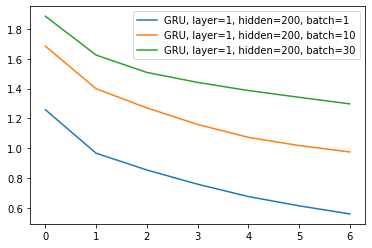

In [186]:
plt.plot(np.arange(7), batch1_trn_losses, label='GRU, layer=1, hidden=200, batch=1')
plt.plot(np.arange(7), batch2_trn_losses, label='GRU, layer=1, hidden=200, batch=10')
plt.plot(np.arange(7), batch3_trn_losses, label='GRU, layer=1, hidden=200, batch=30')
plt.legend()
plt.savefig('train_losses.png')

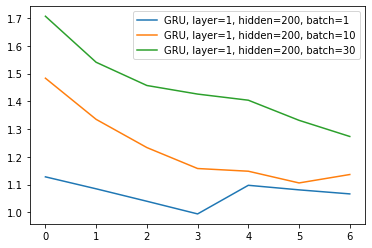

In [187]:
plt.plot(np.arange(7), batch1_val_losses, label='GRU, layer=1, hidden=200, batch=1')
plt.plot(np.arange(7), batch2_val_losses, label='GRU, layer=1, hidden=200, batch=10')
plt.plot(np.arange(7), batch3_val_losses, label='GRU, layer=1, hidden=200, batch=30')
plt.legend()
plt.savefig('val_losses.png')

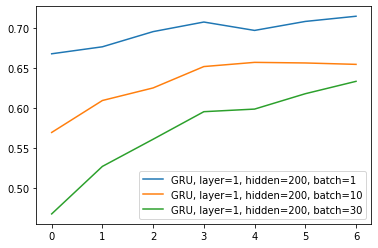

In [188]:
plt.plot(np.arange(7), batch1_val_accs, label='GRU, layer=1, hidden=200, batch=1')
plt.plot(np.arange(7), batch2_val_accs, label='GRU, layer=1, hidden=200, batch=10')
plt.plot(np.arange(7), batch3_val_accs, label='GRU, layer=1, hidden=200, batch=30')
plt.legend()
plt.savefig('val_accuracies.png')